# 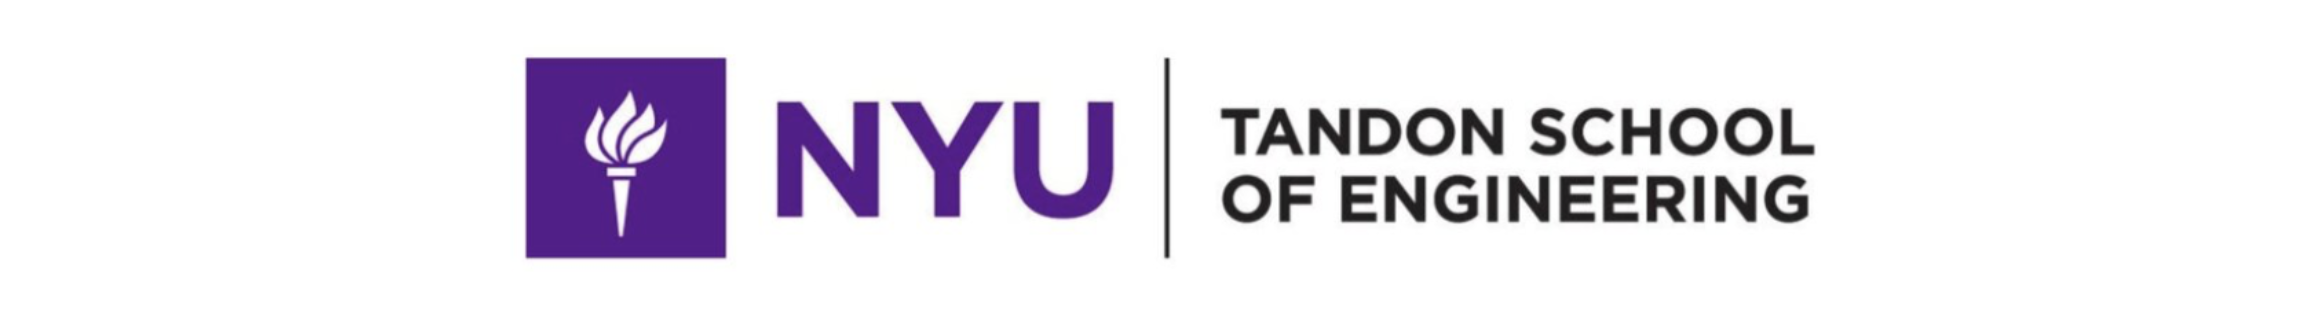

# Reducing Customer Churn in Retail with Personalized Incentives

### Big Data (CSGY-6513-C) | Fall 2024
##### Team Members: 
* Abhishek Agrawal aa9360 
* Shubham Naik svn9724 
* Vaibhav Rouduri vr2470

#### Installing Libraries
* pip3 install pandas
* pip3 install numpy
* pip3 install matplotlib
* pip3 install seaborn
* pip3 install plotly
* pip3 install scikit-learn
* pip3 install xgboost
* pip3 install joblib
* pip3 install boto3
* pip3 install python-dotenv

In [1]:
# Importing Libraries
import os
import io
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split

In [2]:
s3 = boto3.client('s3')
transactions = pd.read_csv(s3.get_object(Bucket='asv-churn-predictor', Key='raw/transaction_data.csv')['Body'])
demographics = pd.read_csv(s3.get_object(Bucket='asv-churn-predictor', Key='raw/hh_demographic.csv')['Body'])
products = pd.read_csv(s3.get_object(Bucket='asv-churn-predictor', Key='raw/product.csv')['Body'])
coupons = pd.read_csv(s3.get_object(Bucket='asv-churn-predictor', Key='raw/coupon.csv')['Body'])

In [3]:
transaction_trends = transactions.groupby(['household_key', 'BASKET_ID', 'STORE_ID', 'DAY', 'WEEK_NO']).agg({
                            'QUANTITY': 'sum', 'SALES_VALUE': 'sum', 'RETAIL_DISC': 'sum', 'COUPON_DISC': 'sum', 'COUPON_MATCH_DISC': 'sum'}).reset_index()

In [4]:
latest_week = int(max(transaction_trends['WEEK_NO'].unique()))
def churn_probability(x):
  if x < 4:
    return round(x/4, 2)
  return 1.00

household_trends = transaction_trends.groupby(['household_key']).agg(
  latest_week_no=('WEEK_NO', 'max'),
  total_weeks=('WEEK_NO', 'nunique'),
  total_quantity=('QUANTITY', 'sum'),
  count_retail_disc=('RETAIL_DISC', lambda x: (x != 0.0).sum()),
  count_coupon_disc=('COUPON_DISC', lambda x: (x != 0.0).sum()),
  count_coupon_match_disc=('COUPON_MATCH_DISC', lambda x: (x != 0.0).sum()),
  total_sales_value=('SALES_VALUE', 'sum'),
  total_retail_disc=('RETAIL_DISC', 'sum'),
  total_coupon_disc=('COUPON_DISC', 'sum'),
  total_coupon_match_disc=('COUPON_MATCH_DISC', 'sum'),
  basket_count=('BASKET_ID', 'count')
).reset_index()

churn_features = household_trends[['household_key']].copy()
churn_features['frequency'] = household_trends['basket_count'] / household_trends['total_weeks']
churn_features['monetary_value'] = household_trends['total_sales_value'] / household_trends['total_weeks']
churn_features['average_basket_size'] = household_trends['total_quantity'] / household_trends['basket_count']
churn_features['discount_utilization'] = (household_trends['total_retail_disc'] + household_trends['total_coupon_disc'] + household_trends['total_coupon_match_disc']) / household_trends['basket_count']
churn_features['discount_count'] = (household_trends['count_retail_disc'] + household_trends['count_coupon_disc'] + household_trends['count_coupon_match_disc']) / household_trends['basket_count']

churn_features['recency'] = latest_week - household_trends['latest_week_no']
churn_features['churn_probability'] = churn_features['recency'].apply(lambda x: churn_probability(x))
churn_features['is_churn'] = churn_features['churn_probability'] > 0.5

churn_features

,household_key,frequency,monetary_value,average_basket_size,discount_utilization,discount_count,recency,churn_probability,is_churn
0,1,1.264706,63.678824,23.220930,-9.345930,1.453488,0,0.00,False
1,2,1.285714,55.838286,18.533333,-7.644222,1.044444,6,1.00,True
2,3,1.270270,71.708378,181.702128,-16.088298,1.191489,1,0.25,False
3,4,1.153846,46.158077,12.733333,-3.938333,0.966667,12,1.00,True
4,5,1.481481,28.854074,6.125000,-2.958250,0.750000,1,0.25,False
...,...,...,...,...,...,...,...,...,...
2495,2496,1.312500,90.409583,2068.317460,-18.715714,1.507937,4,1.00,True
2496,2497,2.569767,82.697442,277.085973,-6.147602,0.895928,1,0.25,False
2497,2498,2.567164,38.829851,182.203488,-1.624419,0.720930,0,0.00,False
2498,2499,1.666667,62.853148,1593.877778,-5.578889,0.844444,0,0.00,False


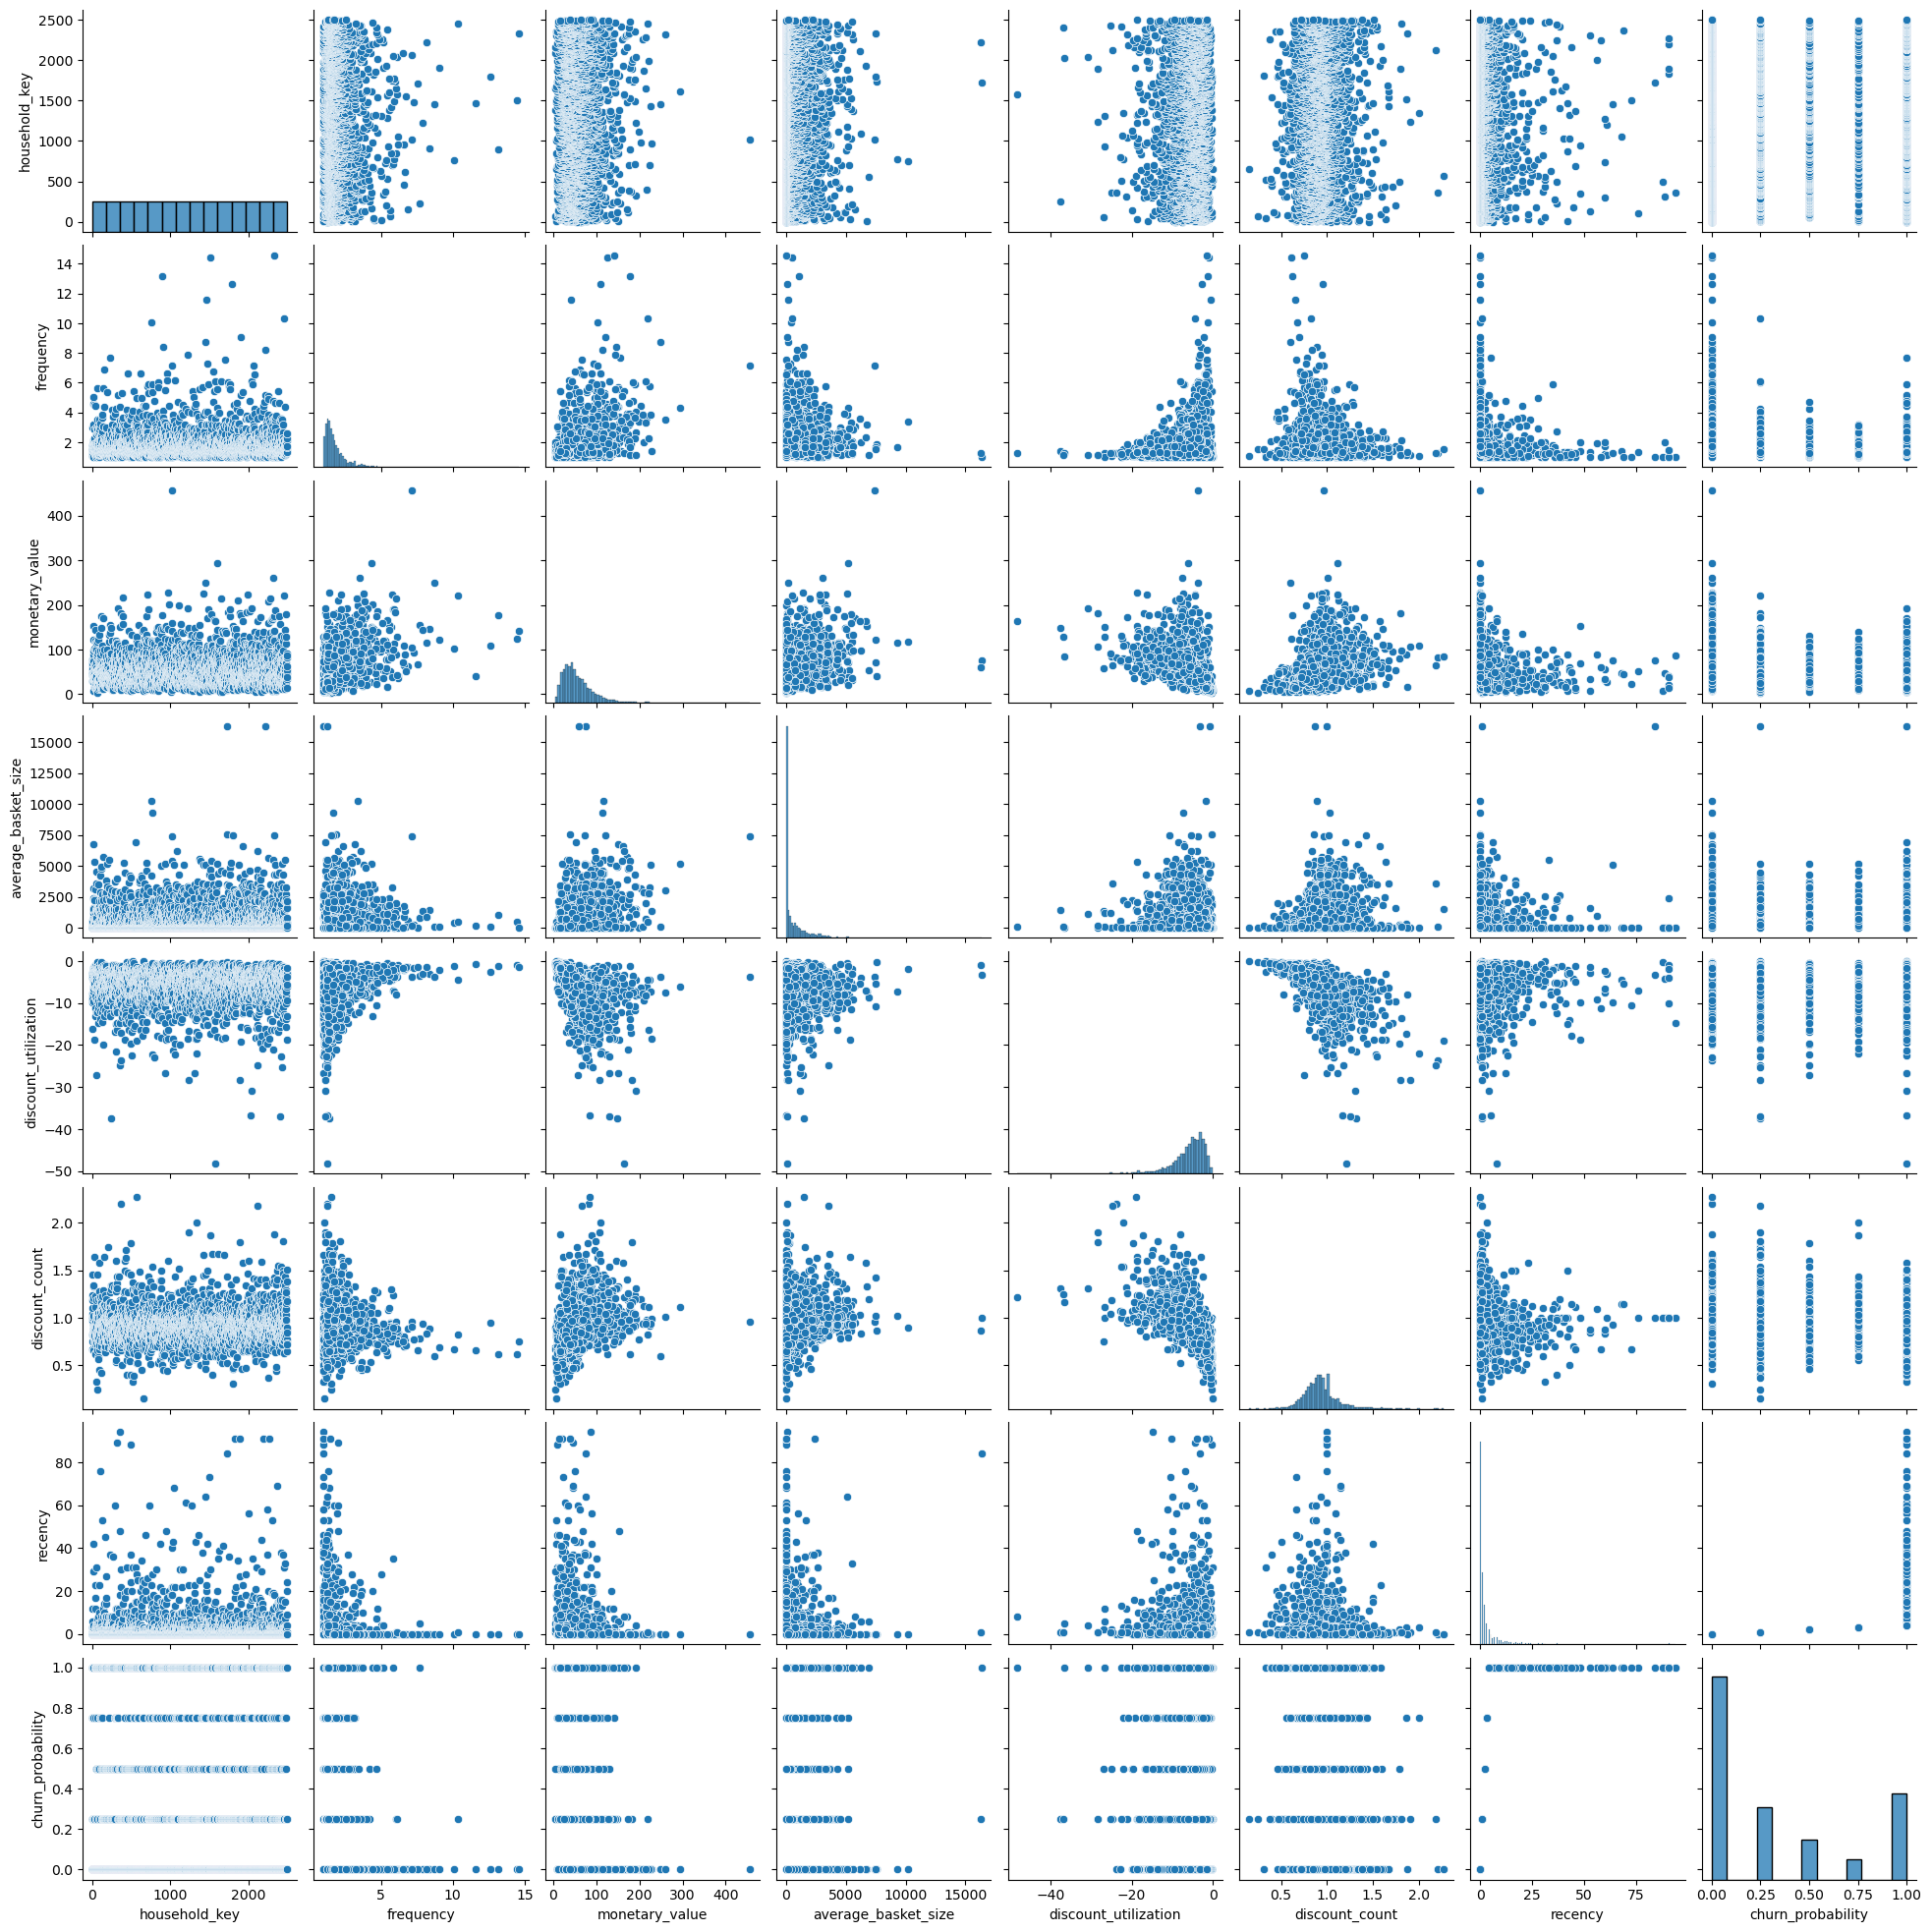

In [5]:
plot_table=churn_features.drop(['is_churn'], axis=1)
sns.pairplot(plot_table)

In [6]:
X, y = churn_features.drop(columns=['is_churn', 'churn_probability', 'recency', 'household_key']), churn_features['is_churn']
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [7]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(Xtr, ytr)
logistic_y_pred = logistic_model.predict(Xts)
logistic_acc = accuracy_score(yts, logistic_y_pred)

print(f"Logistic Regression Accuracy: {logistic_acc}")

Logistic Regression Accuracy: 0.7306666666666667


In [8]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(Xtr, ytr)
mlp_y_pred = mlp_model.predict(Xts)
mlp_acc = accuracy_score(yts, mlp_y_pred)

print(f"MLP Neural Network Accuracy: {mlp_acc}")

MLP Neural Network Accuracy: 0.732


In [9]:
from sklearn.ensemble import RandomForestClassifier

n_splits = 6
kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
models = {}
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
  X_train, X_val = X.iloc[train_index], X.iloc[test_index]
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]
  model = RandomForestClassifier(n_estimators=200, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  models[accuracy_score(y_val, y_pred)] = model

model = models[max(list(models.keys())) ]
y_pred = model.predict(Xts)
print(accuracy_score(yts, y_pred))

0.9626666666666667


In [10]:
feature_weights=sorted(dict(zip(churn_features.drop(columns=['is_churn', 'churn_probability', 'recency', 'household_key']).columns, [float(x) for x in model.feature_importances_])).items(), key=lambda item: item[1])
feature_weights

[('discount_count', 0.17519839345652788),
 ('discount_utilization', 0.18155451039691378),
 ('average_basket_size', 0.19576009731473143),
 ('monetary_value', 0.20465739948740647),
 ('frequency', 0.24282959934442047)]

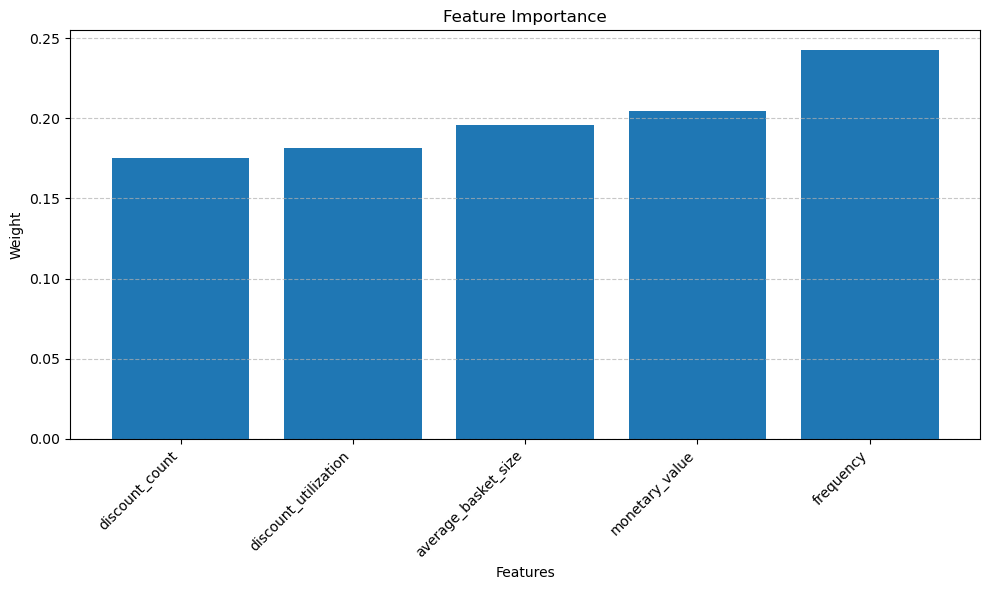

In [11]:
features, weights = zip(*feature_weights)

plt.figure(figsize=(10, 6))
plt.bar(features, weights)

# Customize the plot
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Weight')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [12]:
import joblib
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']